<h1 align="center">PART II</h1>
<h1 align="center">Sentiment Analysis Classifications - Review and Comparison</h1>

First, we needed to create vector words. For simplicity, we used a pre-trained model.

Google was able to teach the Word2Vec model on a massive Google News dataset that contained over 100 billion different words! Google has created [3 million vector words](https://code.google.com/archive/p/word2vec/#Pre-trained_word_and_phrase_vectors) from this model, each with a dimension of 300.

Ideally, we would use these vectors, but because the vector-word matrix is quite large (3.6 GB), we used a much more manageable matrix, which was trained using [GloVe](https://nlp.stanford.edu/projects/glove/), with a similar model of vector word generation. This matrix contains 400,000 vector words, each with a dimension of 50. You can also download model [here](https://www.kaggle.com/anindya2906/glove6b?select=glove.6B.50d.txt).

#### How word2vec works:

The idea behind word2vec is that:

    Take a 3 layer neural network. (1 input layer + 1 hidden layer + 1 output layer)
    Feed it a word and train it to predict its neighbouring word.
    Remove the last (output layer) and keep the input and hidden layer.
    Now, input a word from within the vocabulary. The output given at the hidden layer is the ‘word embedding’ of the input word.
    
Two popular examples of methods of learning word embeddings from text include:

    Word2Vec
    GloVe

To get started, let's download the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import pickle
import gensim, logging
import gensim.models.keyedvectors as word2vec
import matplotlib.pyplot as plt

%matplotlib inline

Also let's write a style for alignment in the middle of all graphs, images, etc:

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Next, we will load the sample data we processed in the previous part:

In [3]:
with open('documents.pql', 'rb') as f:
     docs = pickle.load(f)

In [4]:
print("Number of documents:", len(docs))

Number of documents: 38544


Now we will load our glove model in word2vec format. Because the GloVe dump from Stanford's site is slightly different from the word2vec format. You can convert a GloVe file to word2vec format using the following command in your console:

`python -m gensim.scripts.glove2word2vec --input  model/glove.6B.50d.txt --output model/glove.6B.50d.w2vformat.txt`

After that you can delete original GloVe model.

Next operation may take some time, as the model contains 400 000 words, so we will get a 400 000 x 50 embedding matrix that contains all the values of the word vectors.

In [5]:
model = word2vec.KeyedVectors.load_word2vec_format('model/glove.6B.50d.w2vformat.txt', binary=False)

Now let's get a list of all the words from our dictionary:

In [6]:
words = list(model.vocab)

Just to make sure everything is loaded correctly, we can look at the dimensions of the dictionary list and the embedding matrix:

In [7]:
print(words[:50], "\n\nTotal words:", len(words), "\n\nWord-Vectors shape:", model.vectors.shape)

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as', 'it', 'by', 'at', '(', ')', 'from', 'his', "''", '``', 'an', 'be', 'has', 'are', 'have', 'but', 'were', 'not', 'this', 'who', 'they', 'had', 'i', 'which', 'will', 'their', ':', 'or', 'its', 'one', 'after'] 

Total words: 400000 

Word-Vectors shape: (400000, 50)


We can also find a word like "football" in our word list and then access the corresponding vector through the embedding matrix:

In [8]:
print(model['football'])

[-1.8209    0.70094  -1.1403    0.34363  -0.42266  -0.92479  -1.3942
  0.28512  -0.78416  -0.52579   0.89627   0.35899  -0.80087  -0.34636
  1.0854   -0.087046  0.63411   1.1429   -1.6264    0.41326  -1.1283
 -0.16645   0.17424   0.99585  -0.81838  -1.7724    0.078281  0.13382
 -0.59779  -0.45068   2.5474    1.0693   -0.27017  -0.75646   0.24757
  1.0261    0.11329   0.17668  -0.23257  -1.1561   -0.10665  -0.25377
 -0.65102   0.32393  -0.58262   0.88137  -0.13465   0.96903  -0.076259
 -0.59909 ]


<h2 align="center">Word Average Embedding Model</h2>

Well, let's start analyzing our vectors. Our first approach will be the **word average embedding model**. 

The essence of this naive approach is to take the average of all word vectors from a sentence to get one 50-dimensional vector that represents the tone of the whole sentence that we feed the model and try to get some quick result.

We didn't have to put a try/except, but even though I cleaned up our sample, there were a couple of words left after the processing that needed to be searched for and removed.

In [9]:
def sent_embed(words, docs):
    x_sent_embed, y_sent_embed = [], []
    count_words, count_non_words = 0, 0  
    
    # recover the embedding of each sentence with the average of the vector that composes it
    # sent - sentence, state - state of the sentence (pos/neg)
    for sent, state in docs:
        # average embedding of all words in a sentence
        sent_embed = []
        for word in sent:
            try:
                # if word is present in the dictionary - add its vector representation
                count_words += 1
                sent_embed.append(model[word])
            except KeyError:
                # if word is not in the dictionary - add a zero vector
                count_non_words += 1
                sent_embed.append([0] * 50)
        
        # add a sentence vector to the list
        x_sent_embed.append(np.mean(sent_embed, axis=0).tolist())
        
        # add a label to y_sent_embed
        if state == 'pos': y_sent_embed.append(1)
        elif state == 'neg': y_sent_embed.append(0)
            
    print(count_non_words, "out of", count_words, "words were not found in the vocabulary.")
    
    return x_sent_embed, y_sent_embed

In [10]:
x, y = sent_embed(words, docs)

30709 out of 1802696 words were not found in the vocabulary.


<h2 align="center">Cosine Similarity</h2>

To measure the similarity of 2 words, we need a way to measure the degree of similarity between 2 embedding vectors for these 2 words. Given 2 vectors $u$ and $v$, cosine similarity is determined as follows:

$$\text{cosine_similarity(u, v)} = \frac {u . v} {||u||_2 ||v||_2} = cos(\theta)$$

where: 

* $u.v$ - dot product (or inner product) of two vectors;

* $||u||_2$ - norm (or length) of the vector $u$;
    
    * **Note**: norm of $u$ is defined as $ ||u||_2 = \sqrt{\sum_{i=1}^{n} u_i^2}$)

* $\theta$ is the angle between $u$ and $v$. 

This similarity depends on the angle between $u$ and $v$. If $u$ and $v$ are very similar, their cosine similarity will be close to 1; if they are dissimilar, the cosine similarity will take a smaller value. 

**`cosine_similarity()`** is a method that used to estimate the similarity between word vectors.

In [11]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similariy between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
    
    distance = 0.0
    
    # compute the dot product between u and v
    dot = np.dot(u,v)
    
    # compute the L2 norm of u
    norm_u = np.sqrt(sum(u**2))
    
    # Compute the L2 norm of v
    norm_v = np.sqrt(sum(v**2))
    
    # Compute the cosine similarity defined by formula above
    cosine_similarity = dot/(norm_u*norm_v)
    
    return cosine_similarity

Let's check the cosine similarity on 2 negative sentences:

In [12]:
print("Sentence #5: ", docs[5], "\n\nSentence #7: ", docs[7])
print("\nSentence Embedding #5: ", x[5], "\n\nSentence Embedding #7: ", x[7])

Sentence #5:  (['eager', 'read', 'book', 'reading', 'left', 'completely', 'flat', 'rest', 'iceberg', 'hardly', 'smith', 'barely', 'give', 'could', 'reading', 'sport', 'illustrated', 'minnesota', 'sport', 'page', 'admits', 'football', 'majority', 'book', 'leisurely', 'describes', 'basic', 'part', 'football', 'career', 'book', 'touted', 'full', 'complete', 'story', 'learned', 'watching', 'stimpy', 'draft', 'type', 'meaty', 'story', 'want', 'read', 'telling', 'inside', 'detail', 'smith', 'deal', 'people', 'wanted', 'friend', 'girlfriend', 'star', 'football', 'player', 'friend', 'could', 'trust', 'need', 'trust', 'thought', 'enter', 'mind', 'look', 'hire', 'agent', 'goofing', 'missing', 'class', 'summer', 'covered', 'story', 'time', 'ohio', 'state', 'begin', 'using', 'football', 'smart', 'enough', 'study', 'break', 'coaching', 'process', 'mentally', 'challenging', 'happened', 'plan', 'medical', 'school', 'know', 'story', 'football', 'part', 'iceberg', 'already', 'documented', 'also', 'felt

In [13]:
print("cosine_similarity = ", cosine_similarity(np.array(x[5]), np.array(x[7])))

cosine_similarity =  0.8968743967161681


A value of 0.89 indicates that the sentences are close to each other, and so it is.

Let's check on two positive sentences:

In [14]:
print("Sentence #1: ", docs[1], "\n\nSentence #4: ", docs[4])
print("\nSentence Embedding #1: ", x[1], "\n\nSentence Embedding #4: ", x[4])

Sentence #1:  (['diehard', 'graco', 'daughter', 'born', 'graco', 'snugride', 'rated', 'infant', 'seat', 'stock', 'consumer', 'report', 'infant', 'seat', 'great', 'part', 'travel', 'system', 'loved', 'stroller', 'seat', 'outgrew', 'seat', 'around', 'year', 'tried', 'eddie', 'bauer', 'convertible', 'seat', 'next', 'horrible', 'strap', 'always', 'twisted', 'daughter', 'head', 'always', 'fell', 'forward', 'onto', 'chest', 'fell', 'asleep', 'quickly', 'changed', 'graco', 'comfortsport', 'overhead', 'drop', 'loved', 'padding', 'head', 'rested', 'side', 'carseat', 'instead', 'chest', 'strap', 'never', 'twisted', 'easy', 'heavy', 'around', 'airport', 'outgrew', 'seat', 'decided', 'make', 'switch', 'britax', 'although', 'roundabout', 'rate', 'went', 'marathon', 'thing', 'like', 'infant', 'latch', 'need', 'child', '3yrs', 'higher', 'weight', 'limit', 'roundabout', 'honda', 'accord', 'door', 'husband', 'drive', 'door', 'toyota', 'echo', 'tiny', 'seat', 'perfectly', 'well', 'vehicle', 'forward', '

In [15]:
print("cosine_similarity = ", cosine_similarity(np.array(x[1]), np.array(x[4])))

cosine_similarity =  0.9481159093219256


These sentences are also close to each other. 

So now let's check sentences with different states:

In [16]:
print("Sentence #1: ", docs[0], "\n\nSentence #5: ", docs[6])

Sentence #1:  (['love', 'crate', 'smart', 'little', 'learned', 'zipper', 'undone', 'escape', 'course', 'home', 'find', 'small', 'gift', 'left', 'behind'], 'pos') 

Sentence #5:  (['product', 'generate', 'enough', 'heat', 'provide', 'relief', 'sore', 'aching', 'muscle', 'massaging', 'action', 'actually', 'vibration', 'action', 'heat', 'switched', 'vibration', 'action', 'reduced', 'dramatically'], 'neg')


In [17]:
print("cosine_similarity = ", cosine_similarity(np.array(x[0]), np.array(x[6])))

cosine_similarity =  0.7410293614966914


As we see, our average embedding still has some problems with separating different classes with cosine similarity.

<h2 align="center">Split Corpus</h2>

Now, for further work, we will divide our corpus for training, testing and development sets:

In [18]:
from sklearn.model_selection import train_test_split

# train test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# train dev
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [19]:
print('Length of x_train:', len(x_train), '| Length of y_train:', len(y_train))
print('Length of x_test:  ', len(x_test), '| Length of y_test: ', len(y_test))
print('Length of x_val:   ', len(x_val), '| Length of y_val:  ', len(y_val))

Length of x_train: 24668 | Length of y_train: 24668
Length of x_test:   7709 | Length of y_test:  7709
Length of x_val:    6167 | Length of y_val:   6167


In [20]:
print("Shape of x_train set:", np.array(x_train).shape)

Shape of x_train set: (24668, 50)


<h2 align="center">Visualization of Classification Report</h2>

We will need these methods when we start to visualize our data, so we will write them now.

The following function takes the conclusion of the `classification_report` function as an argument and plots the results ( function is based on [this](https://stackoverflow.com/a/31689645/14467732) solution).

In [21]:
def plot_classification_report(classification_report, title='Classification Report', cmap='RdBu'):
    
    lines = classification_report.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    
    for line in lines[2 : (len(lines) - 5)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

This function is designed to create a heatmap with text in each cell using the matplotlib library (code based on idea from [here](https://stackoverflow.com/a/16124677/14467732)):

In [22]:
def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC, edgecolors='k', linestyle='dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # add color bar
    plt.colorbar(c)

    # add text in each cell 
    show_val(c)

    # proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm_to_inch(figure_width, figure_height))

This function just inserts the text into the cells of the heatmap (idea is taken from [here](https://stackoverflow.com/a/25074150/14467732)):

In [23]:
def show_val(pc, fmt="%.2f", **kw):
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

The last auxiliary function is intended to specify the size of the figure in centimeters in matplotlib, because by default there is only the method `set_size_inches`, therefore, we will convert inches to centimeters and use this method:

In [24]:
def cm_to_inch(*dim):
    inch = 2.54
    return tuple(i/inch for i in dim[0]) if type(dim[0]) == tuple else tuple(i/inch for i in dim)

<h2 align="center">KNN Model</h2>

The K-nearest neighbors (KNN) algorithm is a type of supervised machine learning algorithms. KNN is extremely easy to implement in its most basic form, and yet performs quite complex classification tasks.  It is a lazy learning algorithm since it doesn't have a specialized training phase. Rather, it uses all of the data for training while classifying a new data point or instance.  KNN is also a non-parametric learning algorithm, which means that it doesn't assume anything about the underlying data.


KNN  algorithm simply calculates the distance of a new data point to all other training data points. The distance can be of any type e.g Euclidean or Manhattan etc. It then selects the K-nearest data points, where K can be any integer. Finally it assigns the data point to the class to which the majority of the K data points belong.

Now, let's build KNN classifier model.

First, we import the `KNeighborsClassifier` module and create KNN classifier object by passing argument number of neighbors in `KNeighborsClassifier()` function. Then, fit our model on the train set using `fit()` and perform prediction on the test set using `predict()`.

One way to help find the best value of neighbors is to plot the graph of neighbor value and the corresponding error rate for the dataset. We will plot the mean error for the predicted values of test set for all the neighbor values between 1 and 25.
To do so, let's first calculate the mean of error for all the predicted values where neighbor ranges from 1 and 25:

In [29]:
from sklearn.neighbors import KNeighborsClassifier

error = []

# calculating error for neighbor values between 1 and 25
for i in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))

The next step is to plot the error values against neighbor values:

Text(0, 0.5, 'Mean Error')

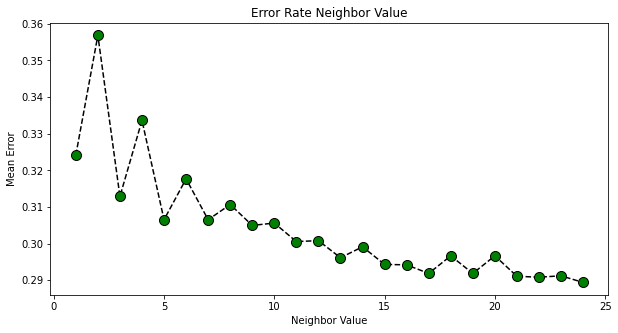

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 25), error, color='black', linestyle='dashed', marker='o', markerfacecolor='green', markersize=10)
plt.title('Error Rate Neighbor Value')
plt.xlabel('Neighbor Value')
plt.ylabel('Mean Error')

As we can see, it is best to take k=5, but still mean error a little higher than normal.

In [34]:
# create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

# train the classifier using the training sets
knn.fit(x_train, y_train)

# predict the response for test dataset
y_pred = knn.predict(x_test)

print("Nearest Neighbors Result (k=5):\n" + '-' * 35)
print("Accuracy Score (k=5):", str(round(knn.score(x_test, y_test) * 100, 2)) + '%')
print("Accuracy (x_train, y_train):", str(round(knn.score(x_train, y_train), 4) * 100) + '%')

Nearest Neighbors Result (k=5):
-----------------------------------
Accuracy Score (k=5): 71.46%
Accuracy (x_train, y_train): 100.0%


The accuracy of the model is good, we can work with it.

Now let's explore our KNN Classification results with help of `classification_report` function from sklearn.metrics:

In [35]:
from sklearn.metrics import classification_report
print('\nClassification KNN:\n', classification_report(y_test, knn.predict(x_test)))


Classification KNN:
               precision    recall  f1-score   support

           0       0.67      0.65      0.66      3292
           1       0.74      0.77      0.75      4417

    accuracy                           0.71      7709
   macro avg       0.71      0.71      0.71      7709
weighted avg       0.71      0.71      0.71      7709



Now finally let's visualize our classification report:

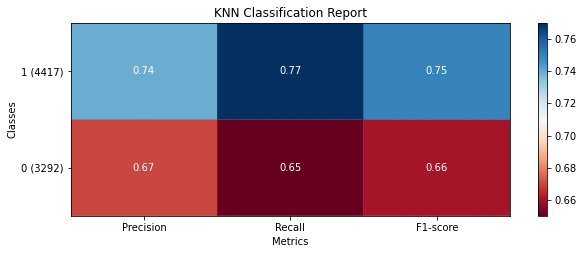

In [36]:
plot_classification_report(classification_report(y_test, knn.predict(x_test)), title='KNN Classification Report')

<h2 align="center">Logistic Regression</h2>

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [37]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(solver='liblinear', multi_class='ovr', n_jobs=1)
logit.fit(x_train, y_train)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

In [40]:
print("Accuracy Score:", str(round(logit.score(x_test, y_test) * 100, 2)) + '%')

Accuracy Score: 72.79%


In [41]:
print('\nClassification Logistic Regression:\n', classification_report(y_test, logit.predict(x_test)))


Classification Logistic Regression:
               precision    recall  f1-score   support

           0       0.70      0.64      0.67      3292
           1       0.75      0.79      0.77      4417

    accuracy                           0.73      7709
   macro avg       0.72      0.72      0.72      7709
weighted avg       0.73      0.73      0.73      7709



Now let's visualize our classification report:

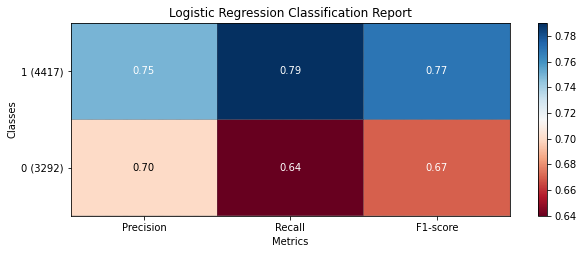

In [42]:
plot_classification_report(classification_report(y_test, logit.predict(x_test)), title='Logistic Regression Classification Report')